In [1]:
import os
import numpy
import xarray
import gzip
import bz2
from datetime import datetime, timedelta

In [2]:
# mapping
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as tck

def mapping_jp(v_data, f_title='', y_unit='', save_flag=0):
    plt.figure(figsize=(10,10))
    jp_extent = (120.0, 150.0, 22.5, 47.5)
    proj=ccrs.PlateCarree()
    ax=plt.axes(projection=proj)
    ax.set_extent(jp_extent,proj)
    ax.coastlines(resolution='10m')
    gl=ax.gridlines(crs=proj,draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = tck.FixedLocator(numpy.arange(120,150,5))
    gl.ylocator = tck.FixedLocator(numpy.arange(20,50,5))
    plt.imshow(v_data, extent=jp_extent, cmap='gist_ncar', interpolation='None')
    plt.colorbar(label=y_unit, shrink=0.7)
    plt.title(f_title)
    if save_flag:
        plt.savefig(os.path.join(STORAGE_FOLDER, f_title+'.png'), dpi=1000)
    else:
        plt.show()

In [3]:
STORAGE_FOLDER = '/data01/people/beichen/workspace/20231124'

In [4]:
# JP extent
resolution = 0.01 # degree
lats = numpy.arange(47.5-resolution/2, 22.5, -resolution)
lons = numpy.arange(120.+resolution/2, 150, resolution)

UTC_OFFSET = 9 # hour
time_internal = 10  # mins

In [5]:
# area_localtime = '2018-07-19T10:30:00Z'
# area_localtime = '2018-07-19T11:00:00Z'
# area_localtime = '2018-07-19T11:30:00Z'
# area_localtime = '2018-07-19T12:00:00Z'
# area_localtime = '2018-07-19T12:30:00Z'
# area_localtime = '2018-07-19T13:00:00Z'
# area_localtime = '2018-07-19T13:30:00Z'
# area_localtime = '2018-07-19T14:00:00Z'
# area_localtime = '2018-07-19T14:30:00Z'
area_localtime = '2018-07-19T15:00:00Z'

## Time info by UTC

In [6]:
area_utc_time = datetime.strptime(area_localtime, "%Y-%m-%dT%H:%M:%SZ") - timedelta(hours=UTC_OFFSET)
area_year = area_utc_time.strftime("%Y")
area_month = area_utc_time.strftime("%m")
area_day = area_utc_time.strftime("%d")
area_hour = area_utc_time.strftime("%H")
area_min = area_utc_time.strftime("%M")

area_utc_year_1day = datetime.strptime(area_year + '-01-01T00:00:00Z', "%Y-%m-%dT%H:%M:%SZ")
time_from_1day = area_utc_time - area_utc_year_1day
area_doy = time_from_1day.days+1
area_doy_str = (3-len(str(area_doy)))*'0' + str(area_doy)

# 1. Calculate Net Radiation

## 1.1 Calculate Rlu

#### R<sub>LU</sub> = 𝜎𝜀<sub>S</sub>𝑇<sub>S</sub><sup>4</sup>

𝜎 is 5.67 × 10<sup>-8</sup> J s<sup>-1</sup> m<sup>-2</sup> K<sup>-4</sup><br>
𝜀<sub>S</sub> is Emissivity from MOD11L2<br>
𝑇<sub>S</sub> is AHI LST

### 1.1.1 Read AHI LST

In [7]:
AHI_LST_FOLDER = '/data01/people/beichen/data_et/AHILST_YY'
lst_filename = os.path.join(AHI_LST_FOLDER, area_utc_time.strftime("%Y%m"), 'AHILST.v0.'+ area_utc_time.strftime("%Y%m%d%H%M") +'.dat.gz')

In [8]:
def read_lst_k(ahi_lst_gz, lst_resolution=0.02):
    with gzip.open(ahi_lst_gz, 'rb') as file:
        gz_data = file.read()
        lst_data = numpy.copy(numpy.frombuffer(gz_data, dtype='f4').reshape(1500, 1500)) # 0.02°
        lst_ds = xarray.Dataset(
            data_vars={
                "values": (("y", "x"), lst_data),
            },
            coords={
                "y": numpy.arange(50-lst_resolution/2, 20, -lst_resolution),
                "x": numpy.arange(120.+lst_resolution/2, 150, lst_resolution)
            },
        )
        jp_ds = lst_ds.interp(x=lons, y=lats, method="nearest", kwargs={"fill_value": "extrapolate"}) # linear
        lst_v = numpy.array(jp_ds.to_array()[0])
        lst_v[lst_v==-999] = numpy.NaN
        lst_data = lst_v + 273.15 # ℃ -> K
        return lst_data

In [9]:
ahi_lst = read_lst_k(lst_filename)

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


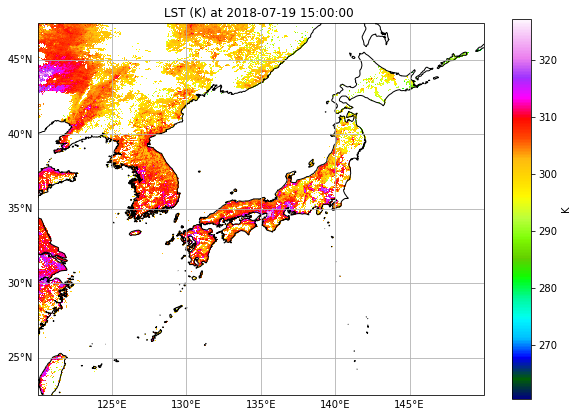

In [10]:
mapping_jp(ahi_lst, 'LST (K) at ' + area_localtime.replace('T', ' ').replace('Z', ' '), 'K')

### 1.1.2 Read MOD11L2 Emissivity

In [11]:
EMIS_LST_FOLDER = '/data01/people/beichen/data_fd_et/MOD21A1D_Emissivity'
emis29_filename = os.path.join(EMIS_LST_FOLDER, area_year, 'MOD21A1D.061_Emis_29_doy' + area_year + area_doy_str + '_aid0001.tif')
emis31_filename = os.path.join(EMIS_LST_FOLDER, area_year, 'MOD21A1D.061_Emis_31_doy' + area_year + area_doy_str + '_aid0001.tif')
emis32_filename = os.path.join(EMIS_LST_FOLDER, area_year, 'MOD21A1D.061_Emis_32_doy' + area_year + area_doy_str + '_aid0001.tif')

In [12]:
def read_emis(modis_emis_tif):
    modis_ds = xarray.open_rasterio(modis_emis_tif)[0]
    jp_ds = modis_ds.interp(x=lons, y=lats, method="nearest", kwargs={"fill_value": "extrapolate"}) # linear
    emis_dn = numpy.array(jp_ds.values)
    emis_dn[emis_dn==0] = numpy.NaN
    data_v = emis_dn*0.002+0.49
    return data_v


def calculate_BBE(band29_emis, band31_emis, band32_emis):
    bbe = 0.227 + 0.188*band29_emis + 0.217*band31_emis + 0.359*band32_emis
    return bbe

In [13]:
emis29_v = read_emis(emis29_filename)
emis31_v = read_emis(emis31_filename)
emis32_v = read_emis(emis32_filename)
emis_bbe = calculate_BBE(emis29_v, emis31_v, emis32_v)

/tmp/ipykernel_3645709/2681531260.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  modis_ds = xarray.open_rasterio(modis_emis_tif)[0]
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float6

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


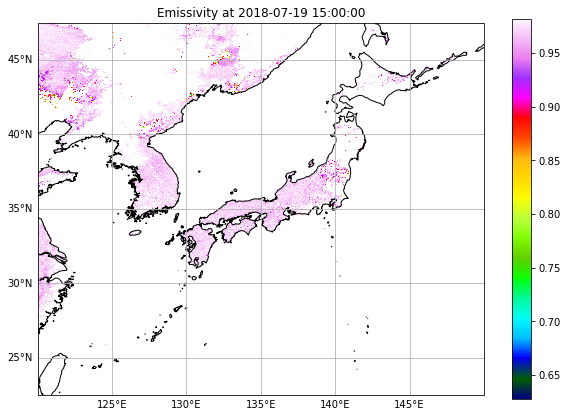

In [14]:
mapping_jp(emis_bbe, 'Emissivity at ' + area_localtime.replace('T', ' ').replace('Z', ''))

### 1.1.3 Calculate Rlu

In [15]:
def calculate_r_lu(epsilon_s, t_s):
    sigma = 5.67e-8
    r_lu = sigma * epsilon_s * t_s**4
    return r_lu

In [16]:
r_lu_area = calculate_r_lu(emis_bbe, ahi_lst)

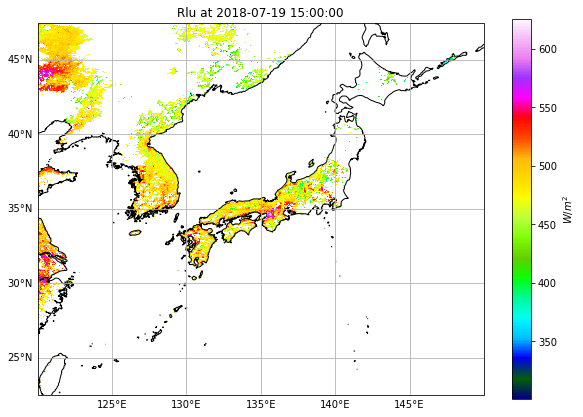

In [17]:
mapping_jp(r_lu_area, 'Rlu at ' + area_localtime.replace('T', ' ').replace('Z', ''), r'$W/m^2$')

## 1.2 Read Rld

In [18]:
ERA5_Rld_FOLDER = '/data01/people/beichen/data_fd_et/ERA5_Rld'
rld_filename = os.path.join(ERA5_Rld_FOLDER, area_year+ '_' + area_month +'.grib')

In [19]:
def read_area_era5_rld_month(era5_rld_grib, area_day, area_hour):
    rld_ds = xarray.load_dataset(era5_rld_grib, engine="cfgrib")
    time_idx = int(area_day)
    step_idx = int(area_hour)-1
    rld_clip = rld_ds.isel(time=time_idx, step=step_idx)
    rld_area_ds = rld_clip.interp(longitude=lons, latitude=lats, method="linear", kwargs={"fill_value": "extrapolate"}) # linear
    
    rld_v_1d = numpy.array(rld_area_ds.to_array()[:,:])/((step_idx+1)*3600)
    return rld_v_1d[0]

In [20]:
r_ld_area = read_area_era5_rld_month(rld_filename, area_day, area_hour)

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


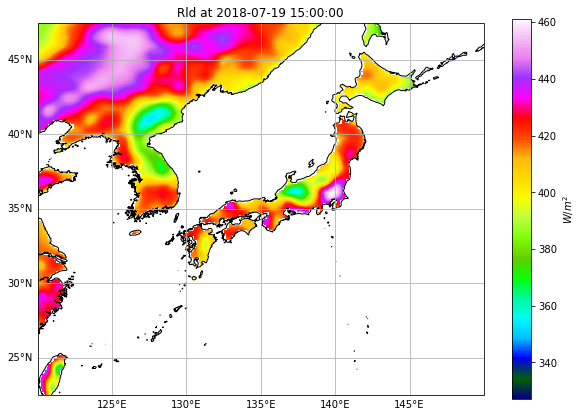

In [21]:
mapping_jp(r_ld_area, 'Rld at ' + area_localtime.replace('T', ' ').replace('Z', ''), r'$W/m^2$')

## 1.3 Read Rsd

In [22]:
RSD_FOLDER = '/data01/people/beichen/data_et/AMATERASS_SRd'
r_sd_filename = os.path.join(RSD_FOLDER, area_utc_time.strftime("%Y%m"), area_utc_time.strftime("%Y%m%d"), area_utc_time.strftime("%Y%m%d%H%M") +'.dwn.sw.flx.sfc.msm.1km.bin.bz2')

In [23]:
def read_AMATERASS_data(bz2_filename):
    pixel_size = 0.01 # 0.01°
    if os.path.exists(bz2_filename):
        try:
            bz2_file = bz2.BZ2File(bz2_filename)
            bz2_data = bz2_file.read()
            jp_data = numpy.frombuffer(bz2_data, dtype='>f4').reshape(2521, 3001)

            ama_ds = xarray.Dataset(
            data_vars={
                "values": (("y", "x"), jp_data),
                },
                coords={
                    "y": numpy.arange(47.6+pixel_size/2, 22.4, -pixel_size),
                    "x": numpy.arange(120.-pixel_size/2, 150, pixel_size)
                },
            )
            jp_ds = ama_ds.interp(x=lons, y=lats, method="nearest", kwargs={"fill_value": "extrapolate"}) # linear
            ama_v = numpy.array(jp_ds.to_array()[0])
            return ama_v
        except Exception as e:
            print(bz2_filename)
            print(e)
            nan_array = numpy.zeros((2521, 3001))
            nan_array[nan_array==0] = numpy.NaN
            return nan_array
            return nan_array
    else:
        nan_array = numpy.zeros((2521, 3001))
        nan_array[nan_array==0] = numpy.NaN
        return nan_array

In [24]:
r_sd_area = read_AMATERASS_data(r_sd_filename)

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


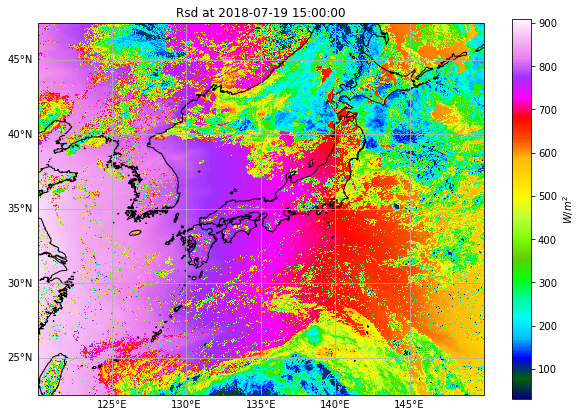

In [25]:
mapping_jp(r_sd_area, 'Rsd at ' + area_localtime.replace('T', ' ').replace('Z', ''), r'$W/m^2$')

## 1.4 Calculate Rsu

### 1.4.1 Read ERA5 Albedo

In [26]:
ERA5_ALBEDO_FOLDER = '/data01/people/beichen/data_et/ERA5_Albedo'
era5_albedo_filename = os.path.join(ERA5_ALBEDO_FOLDER, area_year+ '_' + area_month +'.grib')

In [27]:
def read_area_era5_albedo_month(era5_grib):
    era5_ds = xarray.load_dataset(era5_grib, engine="cfgrib")
    time_idx = int(area_day)
    step_idx = int(area_hour)-1
    era5_clip = era5_ds.isel(time=time_idx, step=step_idx)
    era5_area_ds = era5_clip.interp(longitude=lons, latitude=lats, method="linear", kwargs={"fill_value": "extrapolate"}) # linear
    
    era5_v_1d = numpy.array(era5_area_ds.to_array()[:,:])
    return era5_v_1d[0]

In [28]:
albedo_area = read_area_era5_albedo_month(era5_albedo_filename)

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


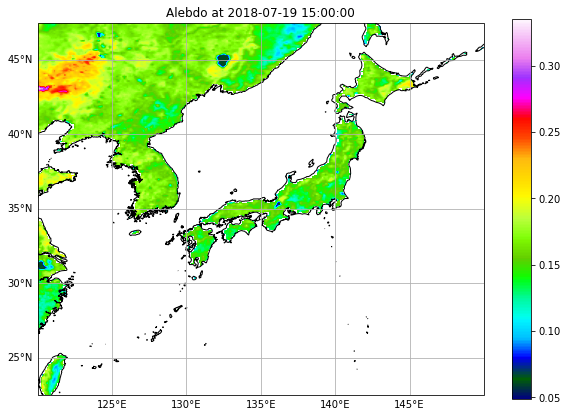

In [29]:
mapping_jp(albedo_area, 'Alebdo at ' + area_localtime.replace('T', ' ').replace('Z', ''))

### 1.4.2 Calculate Rsu

In [30]:
def calculate_r_su(alpha, r_sd):
    r_su = alpha * r_sd
    return r_su

In [31]:
r_su_area = calculate_r_su(albedo_area, r_sd_area)

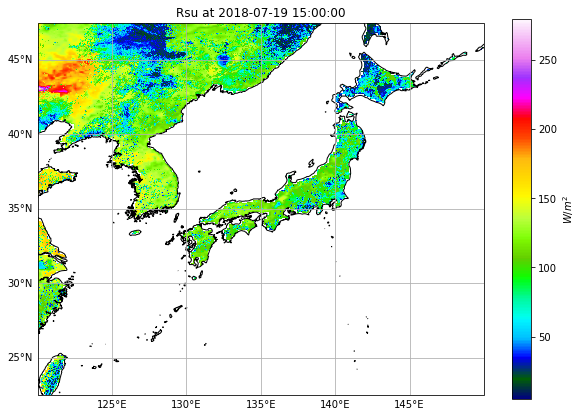

In [32]:
mapping_jp(r_su_area, 'Rsu at ' + area_localtime.replace('T', ' ').replace('Z', ''), r'$W/m^2$')

## 1.5 Calcuate Rnet

In [33]:
def calculate_r_net(r_sd, r_su, r_ld, r_lu):
    r_net = (r_sd - r_su) + (r_ld - r_lu)
    return r_net

In [34]:
r_net_area = calculate_r_net(r_sd_area, r_su_area, r_ld_area, r_lu_area)

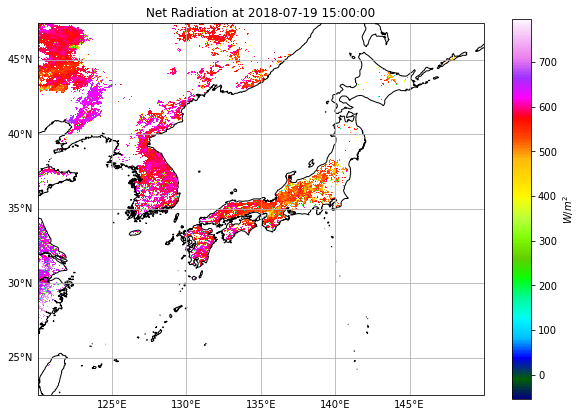

In [35]:
mapping_jp(r_net_area, 'Net Radiation at ' + area_localtime.replace('T', ' ').replace('Z', ''), r'$W/m^2$')

# 2. Read RH

In [36]:
RH_FOLDER = '/data01/people/beichen/data_et/AMATERASS_RH'
rh_filename = os.path.join(RH_FOLDER, area_utc_time.strftime("%Y%m"), area_utc_time.strftime("%Y%m%d"), area_utc_time.strftime("%Y%m%d%H%M") +'.rh.sfc.msm.1km.bin.bz2')

In [37]:
rh_area = read_AMATERASS_data(rh_filename)

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


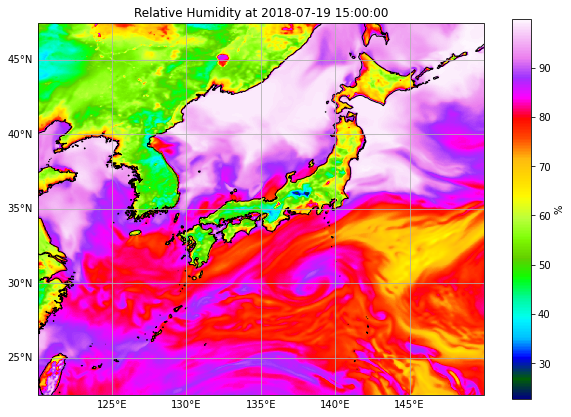

In [38]:
mapping_jp(rh_area, 'Relative Humidity at ' + area_localtime.replace('T', ' ').replace('Z', ''), '%')

# 3. Read Ta

In [39]:
TA_FOLDER = '/data01/people/beichen/data_et/AMATERASS_Ta'
ta_filename = os.path.join(TA_FOLDER, area_utc_time.strftime("%Y%m"), area_utc_time.strftime("%Y%m%d"), area_utc_time.strftime("%Y%m%d%H%M") +'.tsfc.msm.1km.bin.bz2')

In [40]:
ta_area = read_AMATERASS_data(ta_filename)

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


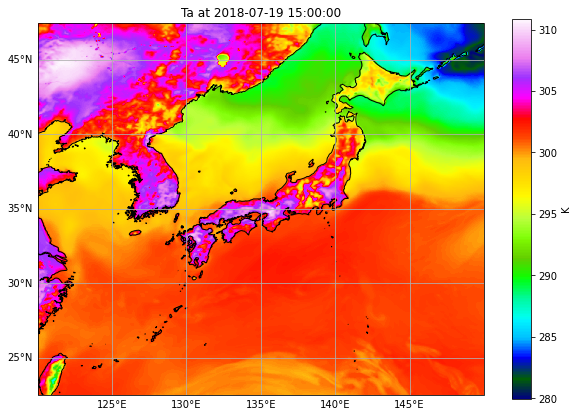

In [41]:
mapping_jp(ta_area, 'Ta at ' + area_localtime.replace('T', ' ').replace('Z', ''), 'K')

# 4. Read NDVI

In [42]:
NDVI_FOLDER = '/data01/people/beichen/workspace/20231120/MOD09GA_NDVI_SMOONTH'
ndvi_filename = os.path.join(NDVI_FOLDER, area_year, area_doy_str+'.npy')

In [43]:
def read_ndvi_npy(ndvi_npy, ndvi_resolution=0.01):
    ndvi_array = numpy.load(ndvi_npy)
    ndvi_ds = xarray.Dataset(
        data_vars={
            "values": (("y", "x"), ndvi_array),
        },
        coords={
            "y": numpy.arange(50-ndvi_resolution/2, 20, -ndvi_resolution),
            "x": numpy.arange(120.+ndvi_resolution/2, 150, ndvi_resolution)
        },
    )
    jp_ds = ndvi_ds.interp(x=lons, y=lats, method="nearest", kwargs={"fill_value": "extrapolate"}) # linear
    ndvi_v = numpy.array(jp_ds.to_array()[0])
    ndvi_v[ndvi_v>1] = numpy.NaN
    ndvi_v[ndvi_v<0] = numpy.NaN
    return ndvi_v

In [44]:
ndvi_area = read_ndvi_npy(ndvi_filename)

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to

/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/data01/people/beichen/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


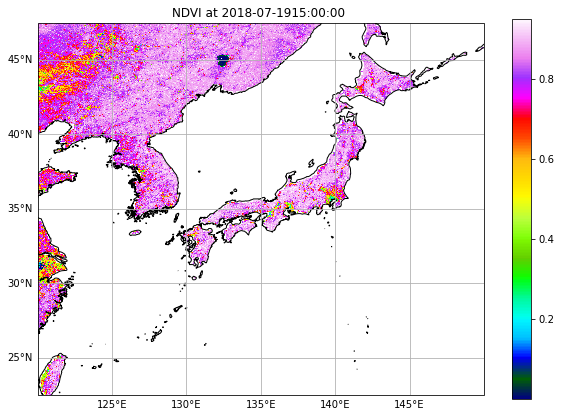

In [45]:
land_mask = numpy.copy(albedo_area)
land_mask[~numpy.isnan(land_mask)] = 1
ndvi_land = ndvi_area*land_mask
mapping_jp(ndvi_land, 'NDVI at ' + area_localtime.replace('T', '').replace('Z', ' '))

# Save Input data

In [46]:
# Rnet
jp_r_net_filename = os.path.join(STORAGE_FOLDER, area_utc_time.strftime("%Y%m%d%H%M") + '_input_jp_r_net.npy')
numpy.save(jp_r_net_filename, r_net_area)
# RH
jp_rh_filename = os.path.join(STORAGE_FOLDER, area_utc_time.strftime("%Y%m%d%H%M") + '_input_jp_rh.npy')
numpy.save(jp_rh_filename, rh_area)
# Ta
jp_ta_filename = os.path.join(STORAGE_FOLDER, area_utc_time.strftime("%Y%m%d%H%M") + '_input_jp_ta.npy')
numpy.save(jp_ta_filename, ta_area)
# NDVI
jp_ndvi_filename = os.path.join(STORAGE_FOLDER, area_utc_time.strftime("%Y%m%d%H%M") + '_input_jp_ndvi.npy')
numpy.save(jp_ndvi_filename, ndvi_land)